# Gtex people allen regions prediction analysis

### By Jianfeng Ke
#### 02/21/2024

In [1]:
import os
import csv
import copy
import math
import time
import random
import pickle
import argparse
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

### Load the prediction and allen dataset

In [3]:
t_epoch = 300
f_epoch = 500
missing_N = 5

save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_8_or_less/Prediction/'
folder_name = f'{t_epoch}_{f_epoch}_by_subject/'
dict_name = f'gtex_allen_region_trainable_GNN_af_epoch_{t_epoch}_fepoch_{f_epoch}_missing_N_{missing_N}.pickle'
# Reading the pickled data from file
with open(save_dir+dict_name, 'rb') as f:
    gtex_allen_region_dict = pickle.load(f)
# read the allen dataset
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_10_103/Prediction/'
dict_name = f'allen_dataset_dict.pickle'
with open(save_dir+dict_name, 'rb') as f:
    allen_dict = pickle.load(f)
    
# the number of subjects in gtex
n_gtex = len(gtex_allen_region_dict.keys())
# the list of gtex subjects
gtex_subject_list = list(gtex_allen_region_dict.keys())
# allen
n_allen = len(allen_dict.keys())
allen_subject_list = list(allen_dict.keys())
# find the gene list
gene_list = allen_dict[allen_subject_list[0]].index.tolist()

In [4]:
# read the DS scores from allen paper
file_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_10_103/'
file_name = 'NIHMS731485-supplement-13.csv'
DS_score = pd.read_csv(file_dir+file_name, index_col=0).sort_index()
overlapped_gene = sorted(list(set(DS_score.index) & set(gene_list)))
# find the indices of overlapped genes in gene list
overlapped_gene_idx = [gene_list.index(x) for x in overlapped_gene]

### Brain-wide DS score of 103 regions evaluation

In [5]:
# dictionary for the pearson correlation between all pairs of subjects
gtex_ds_pairs_dict = {}
# for each pair of gtex subjects
for i in range(n_gtex):
    subject1 = gtex_subject_list[i]
    mat1 = gtex_allen_region_dict[subject1]
    for j in range(n_gtex):
        if i>j:
            subject2 = gtex_subject_list[j]
            mat2 = gtex_allen_region_dict[subject2]
            key_name = f"{subject1}_w_{subject2}"
            corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
            gtex_ds_pairs_dict[key_name] = corr_list

# repeat the steps for allen
allen_ds_pairs_dict = {}
for i in range(n_allen):
    subject1 = allen_subject_list[i]
    mat1 = allen_dict[subject1]
    for j in range(n_allen):
        if i>j:
            subject2 = allen_subject_list[j]
            mat2 = allen_dict[subject2]
            key_name = f"{subject1}_w_{subject2}"
            corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
            allen_ds_pairs_dict[key_name] = corr_list
            
# gtex_allen_pairs
gtex_allen_ds_pairs_dict = {}
for i in range(n_allen):
    subject1 = allen_subject_list[i]
    mat1 = allen_dict[subject1]
    for j in range(n_gtex):
        subject2 = gtex_subject_list[j]
        mat2 = gtex_allen_region_dict[subject2]
        key_name = f"{subject1}_w_{subject2}"
        corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
        gtex_allen_ds_pairs_dict[key_name] = corr_list

# compute the brain-wise DS score
x = list(zip(*gtex_ds_pairs_dict.values()))
gtex_ds_score = [sum(z) / len(z) for z in x]
x = list(zip(*allen_ds_pairs_dict.values()))
allen_ds_score = [sum(z) / len(z) for z in x]
x = list(zip(*gtex_allen_ds_pairs_dict.values()))
gtex_allen_ds_score = [sum(z) / len(z) for z in x]

In [6]:
# compute the spearman correlation between DS score lists
corr, p = spearmanr(allen_ds_score, gtex_ds_score)
print(f'Allen v.s. Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')
corr, p = spearmanr(allen_ds_score, gtex_allen_ds_score)
print(f'Allen v.s. Allen_Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')
corr, p = spearmanr(gtex_allen_ds_score, gtex_ds_score)
print(f'Allen_Gtex v.s. Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')

# compare to the paper
DS_score_overlapped_gene = DS_score['Brainwide125'][overlapped_gene].tolist()
overlapped_gene_idx = [gene_list.index(x) for x in overlapped_gene]
allen_overlapped_ds_score = [allen_ds_score[i] for i in overlapped_gene_idx]
gtex_overlapped_ds_score = [gtex_ds_score[i] for i in overlapped_gene_idx]
gtex_allen_overlapped_ds_score = [gtex_allen_ds_score[i] for i in overlapped_gene_idx]
corr, p = spearmanr(DS_score_overlapped_gene, allen_overlapped_ds_score)
print(f'Paper v.s. Allen: spearman corr: {corr:.4f}, p-value: {p:.4f}')
corr, p = spearmanr(DS_score_overlapped_gene, gtex_overlapped_ds_score)
print(f'Paper v.s. Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')
corr, p = spearmanr(DS_score_overlapped_gene, gtex_allen_overlapped_ds_score)
print(f'Paper v.s. Allen_Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')

Allen v.s. Gtex: spearman corr: 0.4799, p-value: 0.0000
Allen v.s. Allen_Gtex: spearman corr: 0.7082, p-value: 0.0000
Allen_Gtex v.s. Gtex: spearman corr: 0.6645, p-value: 0.0000
Paper v.s. Allen: spearman corr: 0.7980, p-value: 0.0000
Paper v.s. Gtex: spearman corr: 0.4151, p-value: 0.0000
Paper v.s. Allen_Gtex: spearman corr: 0.5040, p-value: 0.0000


In [7]:
# # Allen v.s. Gtex
# corr, p = spearmanr(allen_ds_score, gtex_ds_score)
# plt.figure(figsize=(6, 6))
# plt.plot(allen_ds_score, gtex_ds_score, 'o', markersize=1, color='black')
# # Adding labels and title
# plt.xlabel('Allen DS score')
# plt.ylabel('Gtex DS score')
# plt.title(f'spearman corr: {corr:.4f}, p-value: {p:.4f}')
# # Displaying the plot
# plt.grid(True)
# plt.show()

In [8]:
# # Paper v.s. Allen
# # spearman correlation plot for DS score from paper v.s. allen ds score from us
# # find the ds score for overlapped genes in DS score
# DS_score_overlapped_gene = DS_score['Brainwide125'][overlapped_gene].tolist()
# # find the ds score for overlapped genes in allen
# overlapped_gene_idx = [gene_list.index(x) for x in overlapped_gene]
# ds_score_list = allen_ds_score
# #ds_score_list = gtex_ds_score
# ds_score_overlapped_gene = [ds_score_list[i] for i in overlapped_gene_idx]

# corr, p = spearmanr(DS_score_overlapped_gene, ds_score_overlapped_gene)
# plt.figure(figsize=(6, 6))
# plt.plot(DS_score_overlapped_gene, ds_score_overlapped_gene, 'o', markersize=1, color='black')
# # Adding labels and title
# plt.xlabel('DS score in the paper')
# plt.ylabel('Allen DS score')
# # plt.ylabel('Gtex DS score')
# plt.title(f'overlapped gene: {len(overlapped_gene)}; spearman corr: {corr:.4f}, p-value: {p:.4f}', size=9)
# # Displaying the plot
# plt.grid(True)
# plt.show()

In [9]:
# # Paper v.s. Gtex
# # spearman correlation plot for DS score from paper v.s. allen ds score from us
# # find the ds score for overlapped genes in DS score
# DS_score_overlapped_gene = DS_score['Brainwide125'][overlapped_gene].tolist()
# # find the ds score for overlapped genes in allen
# overlapped_gene_idx = [gene_list.index(x) for x in overlapped_gene]
# #ds_score_list = allen_ds_score
# ds_score_list = gtex_ds_score
# ds_score_overlapped_gene = [ds_score_list[i] for i in overlapped_gene_idx]

# corr, p = spearmanr(DS_score_overlapped_gene, ds_score_overlapped_gene)
# plt.figure(figsize=(6, 6))
# plt.plot(DS_score_overlapped_gene, ds_score_overlapped_gene, 'o', markersize=1, color='black')
# # Adding labels and title
# plt.xlabel('DS score in the paper')
# #plt.ylabel('Allen DS score')
# plt.ylabel('Gtex DS score')
# plt.title(f'overlapped gene: {len(overlapped_gene)}; spearman corr: {corr:.4f}, p-value: {p:.4f}', size=9)
# # Displaying the plot
# plt.grid(True)
# plt.show()

### DS score of 56 unseen regions

In [10]:
# all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']
# save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'
# GeneExpression_allen_dict = {}
# # iterate over all 6 subjects
# for i in range(len(all_ids)):
#     donor = all_ids[i]
#     file_name = save_path + "normalized_expr_" + donor + ".csv"
#     normalized_mat = pd.read_csv(file_name, header = 0)
#     normalized_mat = normalized_mat.set_index('gene_symbol')
#     GeneExpression_allen_dict[donor] = normalized_mat

# # find those 56 unseen regions
# allen_data_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/allen/'
# ontology_path = allen_data_path + 'normalized_microarray_donor' + '9861' + '/Ontology.csv'
# ontology = pd.read_csv(ontology_path, header = 0)
# # From the ontology file, find the sub-regions in allen under gtex region
# gtex_map_path = allen_data_path + "map_gtex_structure.txt"
# gTex_map_dict = {}
# print("Total number of regions in allen ontology:", ontology.shape[0])
# for i in open(gtex_map_path):
#     i = i.strip().split("\t")
#     gtex_region = i[0].strip()
#     allen_region = i[1].strip()
#     if((allen_region == "none?") | (allen_region == 'pituitary body')):
#         continue
#     covered_allen_region = ontology.loc[(ontology['name']==allen_region) | ontology['structure_id_path'].str.startswith(ontology.loc[ontology['name']==allen_region, 'structure_id_path'].values[0]), 'id']
#     gTex_map_dict[gtex_region] = covered_allen_region.tolist()
#     print(gtex_region, "-->", allen_region, ";  number of regions in allen:", len(covered_allen_region))
# print("\n")
# # find those used regions
# intersected_region = GeneExpression_allen_dict['9861'].columns.tolist()
# used_intersected_region_dict = {}
# # unseen_intersected_region_dict = {}
# for gtex_region, covered_allen_region in gTex_map_dict.items():
#     used_region_list = [x for x in intersected_region if int(x) in covered_allen_region]
#     used_intersected_region_dict[gtex_region] = used_region_list
#     print(gtex_region, " # regions expired:", len(used_region_list))
    
# used_region_list = []
# for k, v in used_intersected_region_dict.items():
#     used_region_list = used_region_list + v
# all_region = gtex_allen_region_dict['GTEX-1313W'].columns.tolist()
# unseen_region_list = [x for x in all_region if x not in used_region_list]

In [11]:
# # dictionary for the pearson correlation between all pairs of subjects
# gtex_ds_pairs_dict = {}
# # for each pair of gtex subjects
# for i in range(n_gtex):
#     subject1 = gtex_subject_list[i]
#     mat1 = gtex_allen_region_dict[subject1][unseen_region_list]
#     for j in range(n_gtex):
#         if i>j:
#             subject2 = gtex_subject_list[j]
#             mat2 = gtex_allen_region_dict[subject2][unseen_region_list]
#             key_name = f"{subject1}_w_{subject2}"
#             corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
#             gtex_ds_pairs_dict[key_name] = corr_list

# # repeat the steps for allen
# allen_ds_pairs_dict = {}
# for i in range(n_allen):
#     subject1 = allen_subject_list[i]
#     mat1 = allen_dict[subject1][unseen_region_list]
#     for j in range(n_allen):
#         if i>j:
#             subject2 = allen_subject_list[j]
#             mat2 = allen_dict[subject2][unseen_region_list]
#             key_name = f"{subject1}_w_{subject2}"
#             corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
#             allen_ds_pairs_dict[key_name] = corr_list
            
# # gtex_allen_pairs
# gtex_allen_ds_pairs_dict = {}
# for i in range(n_allen):
#     subject1 = allen_subject_list[i]
#     mat1 = allen_dict[subject1][unseen_region_list]
#     for j in range(n_gtex):
#         subject2 = gtex_subject_list[j]
#         mat2 = gtex_allen_region_dict[subject2][unseen_region_list]
#         key_name = f"{subject1}_w_{subject2}"
#         corr_list = mat1.corrwith(mat2, axis=1, method='pearson').tolist()
#         gtex_allen_ds_pairs_dict[key_name] = corr_list

# # compute the brain-wise DS score
# x = list(zip(*gtex_ds_pairs_dict.values()))
# gtex_ds_score = [sum(z) / len(z) for z in x]
# x = list(zip(*allen_ds_pairs_dict.values()))
# allen_ds_score = [sum(z) / len(z) for z in x]
# x = list(zip(*gtex_allen_ds_pairs_dict.values()))
# gtex_allen_ds_score = [sum(z) / len(z) for z in x]

In [12]:
# # compute the spearman correlation between DS score lists
# corr, p = spearmanr(allen_ds_score, gtex_ds_score)
# print(f'Allen v.s. Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')
# corr, p = spearmanr(allen_ds_score, gtex_allen_ds_score)
# print(f'Allen v.s. Allen_Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')
# corr, p = spearmanr(gtex_allen_ds_score, gtex_ds_score)
# print(f'Allen_Gtex v.s. Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')

# # compare to the paper
# DS_score_overlapped_gene = DS_score['Brainwide125'][overlapped_gene].tolist()
# overlapped_gene_idx = [gene_list.index(x) for x in overlapped_gene]
# allen_overlapped_ds_score = [allen_ds_score[i] for i in overlapped_gene_idx]
# gtex_overlapped_ds_score = [gtex_ds_score[i] for i in overlapped_gene_idx]
# gtex_allen_overlapped_ds_score = [gtex_allen_ds_score[i] for i in overlapped_gene_idx]
# corr, p = spearmanr(DS_score_overlapped_gene, allen_overlapped_ds_score)
# print(f'Paper v.s. Allen: spearman corr: {corr:.4f}, p-value: {p:.4f}')
# corr, p = spearmanr(DS_score_overlapped_gene, gtex_overlapped_ds_score)
# print(f'Paper v.s. Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')
# corr, p = spearmanr(DS_score_overlapped_gene, gtex_allen_overlapped_ds_score)
# print(f'Paper v.s. Allen_Gtex: spearman corr: {corr:.4f}, p-value: {p:.4f}')

### Gene expression histogram by regions for one subject

In [28]:
x=0.70
for i in range(len(gtex_ds_score)):
    if gtex_ds_score[i]>x:
        if allen_ds_score[i]>x:
            print(f'{gene_list[i]}, {i}, {gtex_ds_score[i]}, {allen_ds_score[i]}')

AACS, 6, 0.7074750289654451, 0.8382910188374455
ABCC12, 45, 0.7075994271643984, 0.8034354336208175
AC016747.3, 100, 0.7227369834952324, 0.7226099732895342
ADAM11, 214, 0.7393484878970016, 0.868461934457868
ADCY1, 263, 0.7122158581211948, 0.8407987677502514
ADIPOR2, 286, 0.7349469398498127, 0.7002394895692327
ADSSL1, 312, 0.72095080039777, 0.7823312828621264
AIF1L, 373, 0.7195578202057933, 0.78680007171689
AMPD3, 508, 0.7543389225386385, 0.8595992508449369
ANKRD24, 571, 0.7281643647103486, 0.8777902434568456
ANLN, 610, 0.7104918628775803, 0.8461823855726675
ANXA4, 636, 0.7206451036922946, 0.7237537277129455
ANXA5, 637, 0.727830128052919, 0.7191877073953477
APBB2, 678, 0.7100298585518742, 0.8291003794009792
APOC1, 704, 0.7818267708639721, 0.8813577588325588
APOD, 707, 0.7565069284001369, 0.8258328187731568
ARHGAP26, 775, 0.7275302128074329, 0.7860845233807839
ARRDC2, 870, 0.7273501548209199, 0.8244949056632265
ASPA, 930, 0.7060861703914889, 0.7218510784468842
ASXL3, 947, 0.74678465962294

In [14]:
allen_ds_score[gene_list.index('NGEF')]

0.9234144161087338

In [15]:
gtex_ds_score[gene_list.index('NGEF')]

0.6748176333887751

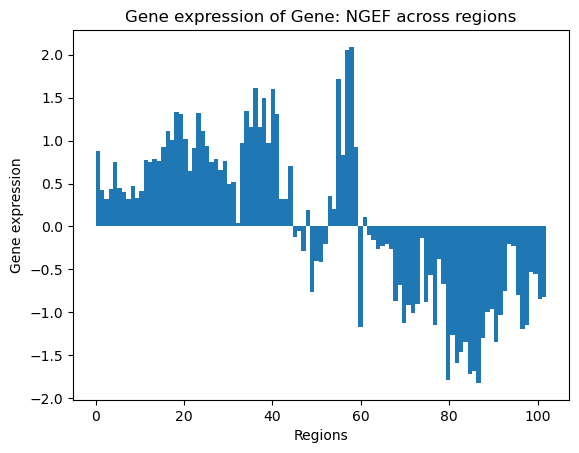

In [16]:
# These genes have high DS score in both datasets:
# 1766, 2055, 2455, 4372, 6182, 6412, 6449, 10783, 11121, 12884
# gene = gene_list[1766]
gene = 'NGEF'

n_region = allen_dict[subject1].shape[1]
subject1 = allen_subject_list[0]
allen_exp = allen_dict[subject1].loc[gene].tolist()
subject2 = gtex_subject_list[0]
gtex_exp = gtex_allen_region_dict[subject2].loc[gene].tolist()

# Plotting histogram
plt.hist(range(n_region), bins=n_region, weights=allen_exp)
plt.xlabel('Regions')
plt.ylabel('Gene expression')
plt.title('Gene expression of Gene: NGEF across regions')

plt.show()

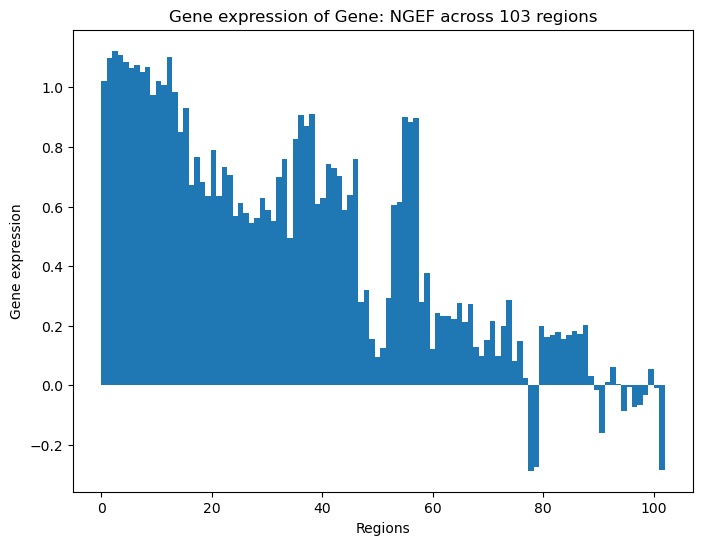

In [17]:
# Plotting histogram
plt.figure(figsize=(8,6))
plt.hist(range(n_region), bins=n_region, weights=gtex_exp)
plt.xlabel('Regions')
plt.ylabel('Gene expression')
plt.title('Gene expression of Gene: NGEF across 103 regions')

plt.show()

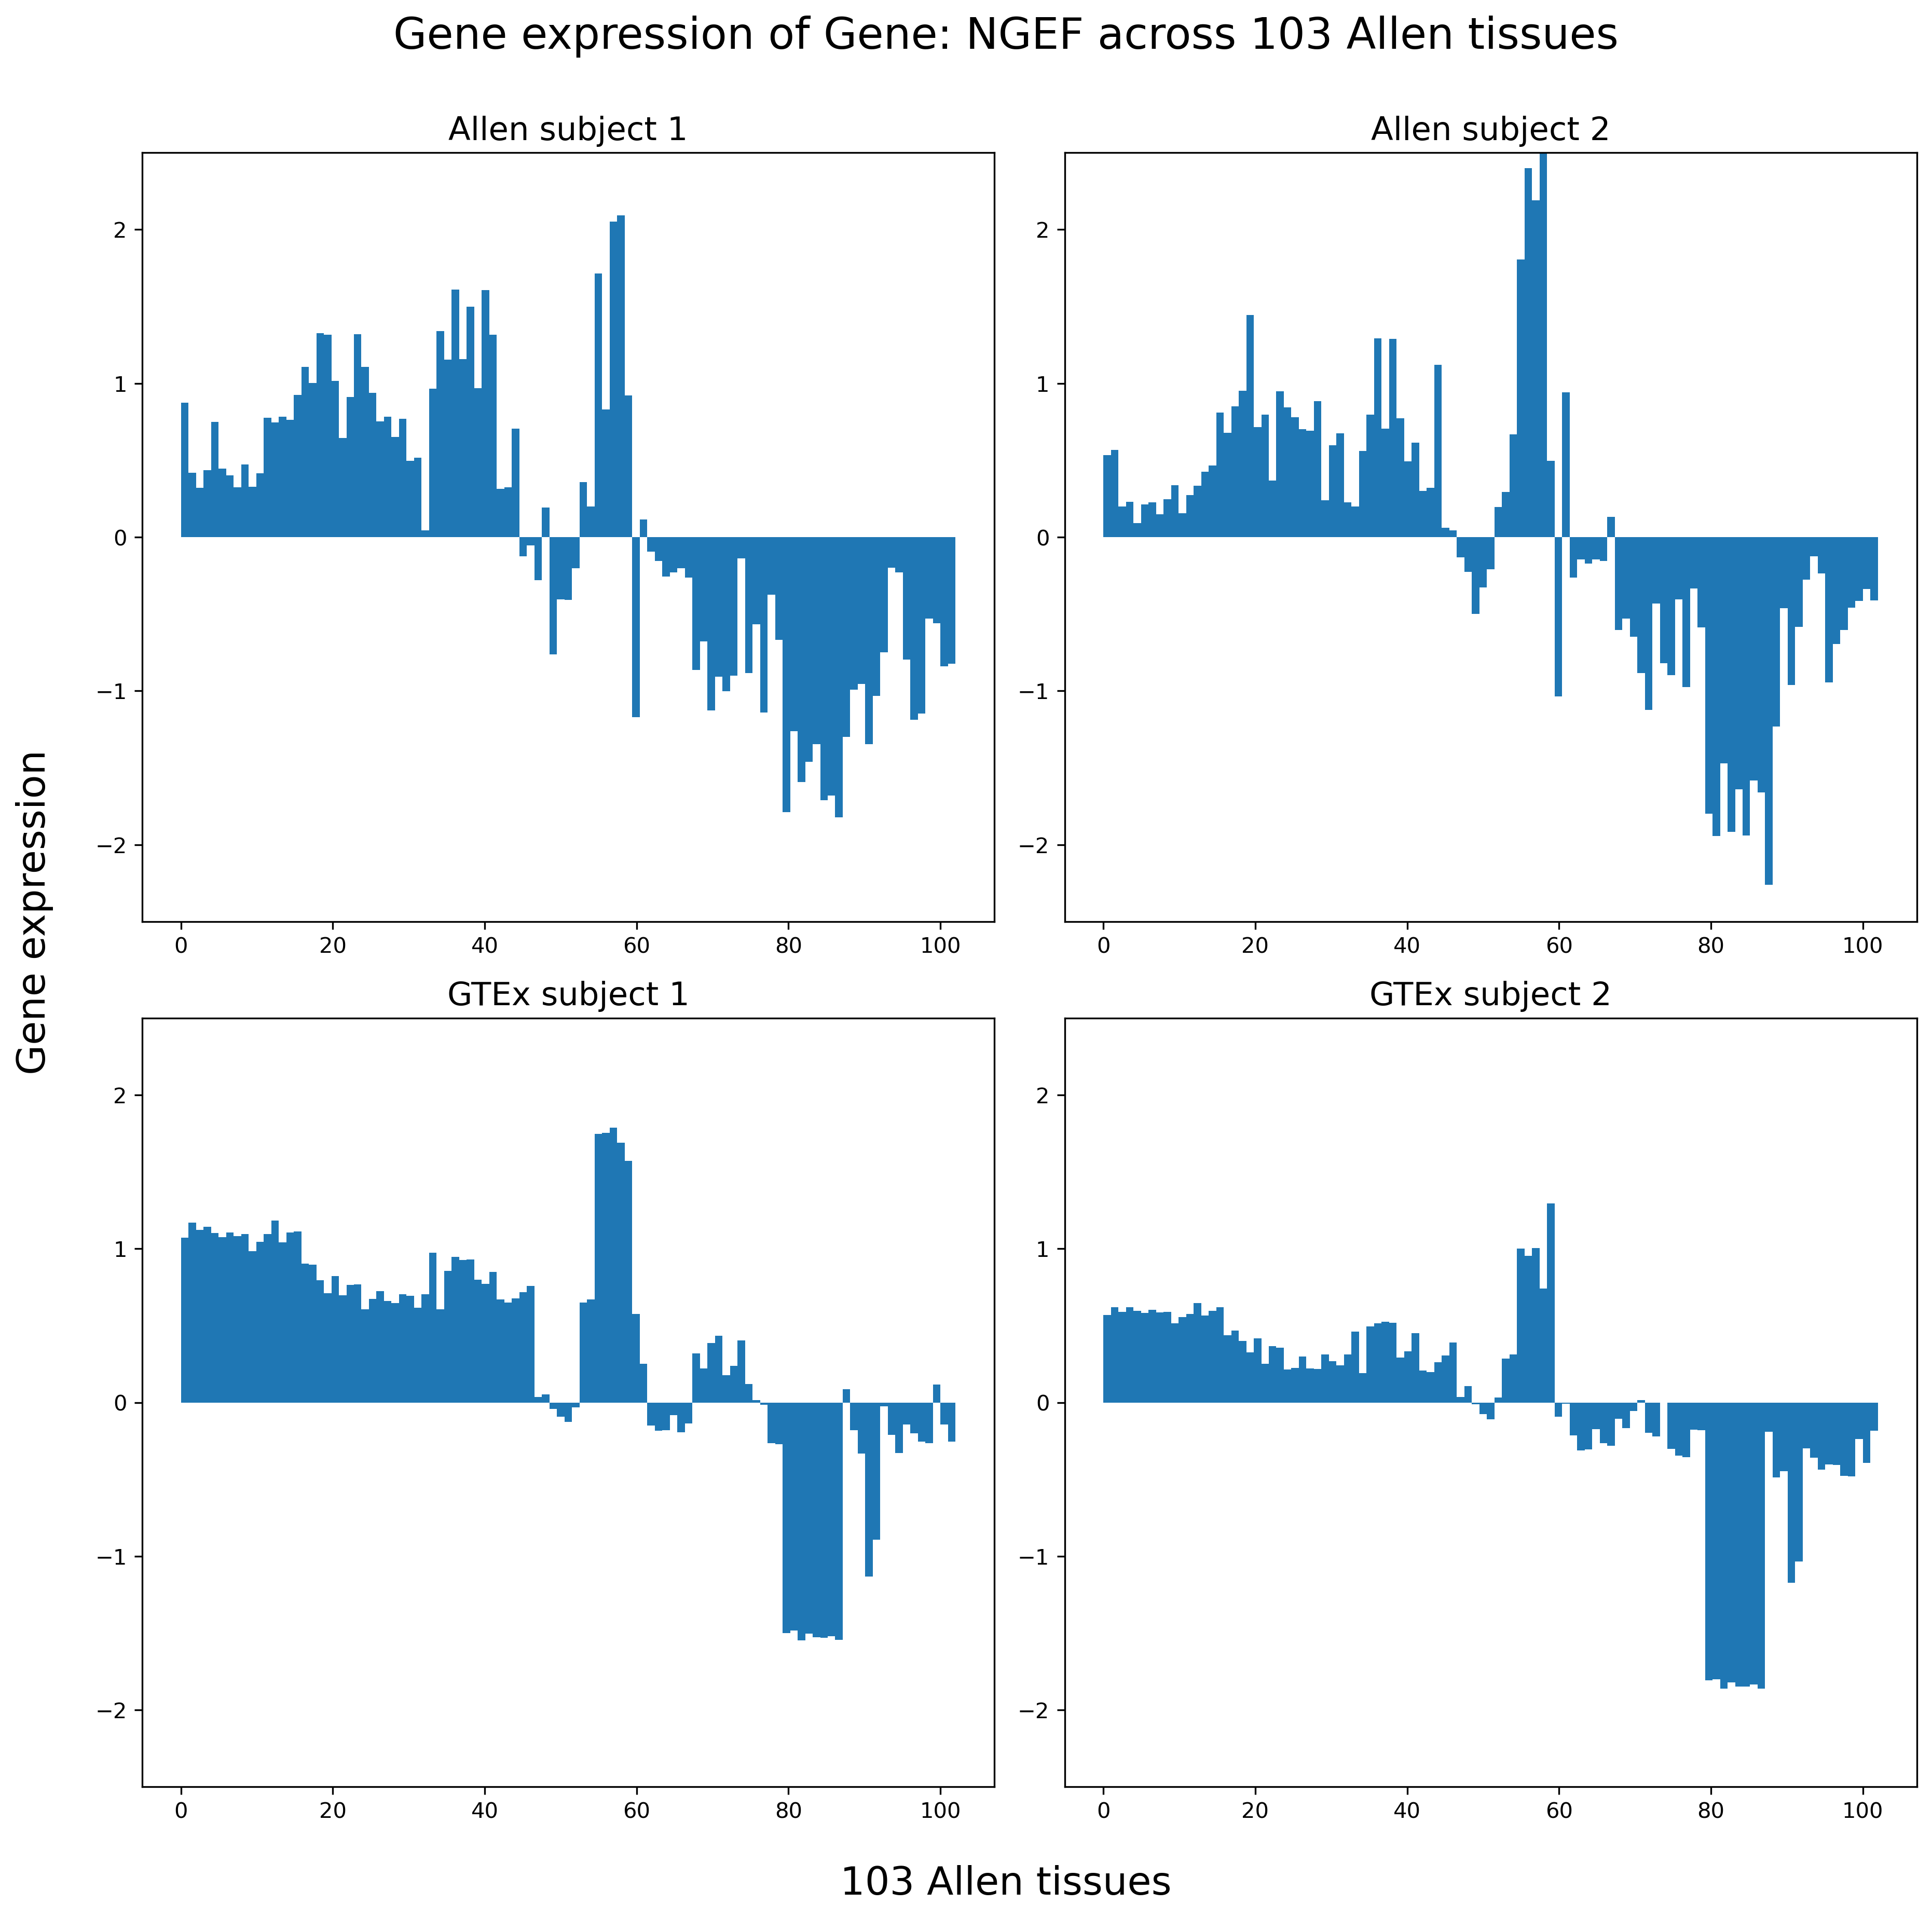

In [38]:
gene = 'NGEF'
# ['GTEX-1313W', 'GTEX-13NYB', 'GTEX-13O3O', 'GTEX-13O3Q', 'GTEX-13OW8']
 
# gtex_subject1 = gtex_subject_list[20]
# gtex_subject2 = gtex_subject_list[21]
gtex_subject1 = 'GTEX-1313W'
gtex_subject2 = 'GTEX-13NYB'
 
# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi=300)
exp_mat_list = [allen_dict[allen_subject_list[0]], allen_dict[allen_subject_list[1]], 
                gtex_allen_region_dict[gtex_subject1], gtex_allen_region_dict[gtex_subject2]]
title_list = ['Allen subject 1', 'Allen subject 2', 'GTEx subject 1', 'GTEx subject 2']
# Plotting each subplot
for i, ax in enumerate(axes.flat):
    exp = exp_mat_list[i].loc[gene].tolist()
    ax.hist(range(n_region), bins=n_region, weights=exp)
    ax.set_title(title_list[i], fontsize=15)
# Set common xlim and ylim for the entire figure
for ax in axes.flat:
    ax.set_ylim(-2.5, 2.5)

# Add xlabel and ylabel for the entire figure
fig.text(0.5, -0.02, '103 Allen tissues', ha='center', va='center', fontsize=18)
fig.text(-0.02, 0.5, 'Gene expression', ha='center', va='center', rotation='vertical', fontsize=18)
fig.suptitle(f'Gene expression of Gene: {gene} across 103 Allen tissues\n', fontsize=20)
# Adjust layout and display the plot
plt.tight_layout()

plt.show()